In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
pixel_to_micrometer = 200/461
dy = 10 * pixel_to_micrometer
dl = 6 * 2 * pixel_to_micrometer
dt = 0.1

In [12]:
df = pd.read_csv("csvs/heights/straight_61.4_10cm_img4.csv")
df["Velocity (μm/ms)"].sort_values().iloc[5:]

4    0.529981
2    0.558376
3    0.565307
9    0.608028
0    0.659545
Name: Velocity (μm/ms), dtype: float64

In [5]:
def process(path, exposure):
    df = pd.read_csv(path)
    velocity = df["Velocity (μm/ms)"].sort_values().iloc[5:]
    length = df["Length (μm)"].sort_values().iloc[5:]
    uncertainty = np.mean(np.array(velocity)*np.sqrt((dt/exposure)**2 + 
                    (dl/np.array(length))**2))
    return np.mean(velocity), uncertainty

heights = [10, 13, 16, 20]
heights = np.array(heights) * 10000

h_10 = process("csvs/heights/straight_61.4_10cm_img4.csv", 61.4)
h_13 = process("csvs/heights/straight_50.6_13cm_img6.csv", 50.6)
h_16 = process("csvs/heights/straight_50.6_16cm_img7.csv", 50.6)
h_20 = process("csvs/heights/straight_55.7_20cm_img10.csv", 55.7)

velocity = [h_10[0], h_13[0], h_16[0], h_20[0]]
uncertainty = [h_10[1], h_13[1], h_16[1], h_20[1]]

In [6]:
def linear(x, a, b):
    return a*x + b

def power(x, a, b):
    return a*x**b

coeff, covar = scipy.optimize.curve_fit(power, heights, velocity)
h_fit = np.linspace(min(heights), max(heights), 500)
v_fit = power(h_fit, *coeff)


In [7]:
coeff

array([1.26046953e-06, 1.13954451e+00])

In [8]:
#get the uncertainty in parameters
perr = np.sqrt(np.diag(covar))
perr

array([2.20942021e-06, 1.45981934e-01])

In [9]:
# Residuals
residuals = velocity - power(np.array(heights), *coeff)

# R^2 calculation
ss_res = np.sum(residuals**2)
ss_tot = np.sum((velocity - np.mean(velocity))**2)
r_squared = 1 - (ss_res / ss_tot)

# Reduced chi^2 calculation
# If you have uncertainties, replace 1 with your sigma values
sigma = uncertainty
chi_squared = np.sum((residuals / sigma)**2)
degrees_of_freedom = len(velocity) - len(coeff)
reduced_chi_squared = chi_squared / degrees_of_freedom

print(f"R^2: {r_squared}")
print(f"Reduced Chi^2: {reduced_chi_squared}")

R^2: 0.9724782321144482
Reduced Chi^2: 0.4693765126529505


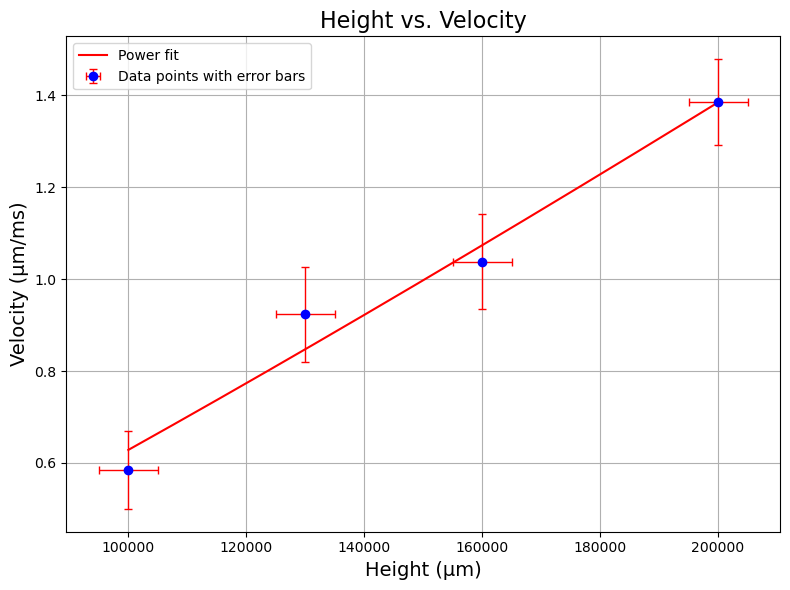

In [12]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(h_fit, v_fit, color='red', label='Power fit')
plt.errorbar(
    heights,
    velocity,
    xerr=0.5 * 10000,
    yerr=uncertainty,
    fmt='o',
    color='blue',
    ecolor='red',
    elinewidth=1,
    capsize=3,
    label='Data points with error bars'
)
plt.ylabel('Velocity (μm/ms)', fontsize=14)
plt.xlabel('Height (μm)', fontsize=14)
plt.title('Height vs. Velocity', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()